# Phishing-Url-Detection-Analysis

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix


# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier


# Functions

In [50]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def convert_boolean_cols(df, columns):
  
  for col in columns:
    df[col] = df[col].apply(lambda x: 1 if x == True else 0)
  
  return df

# EDA Analysis

In [39]:
legit_records, phishing_records = [], []
chunk_size = 10000
file_path = "/Users/maukanmir/Downloads/out.csv"
target_labels = ['legitimate', 'phishing']
target_count = 12500
legitimate_count = 0
phishing_count = 0

for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    filtered_chunk = chunk[chunk['label'].isin(target_labels)]

    legitimate_chunk = filtered_chunk[filtered_chunk['label'] == 'legitimate']
    phishing_chunk = filtered_chunk[filtered_chunk['label'] == 'phishing']
    
    if legitimate_count < target_count:
        legit_needed = target_count - legitimate_count
        legit_records.append(legitimate_chunk[:legit_needed])
        legitimate_count += len(legitimate_chunk[:legit_needed])
    
    if phishing_count < target_count:
        phishing_needed = target_count - phishing_count
        phishing_records.append(phishing_chunk[:phishing_needed])
        phishing_count += len(phishing_chunk[:phishing_needed])
    
    if legitimate_count >= target_count and phishing_count >= target_count:
        break

final_legitimate_df = pd.concat(legit_records)
final_phishing_df = pd.concat(phishing_records)
df = pd.concat([final_legitimate_df, final_phishing_df])

In [41]:
df.describe()

,url_length,url_entropy,digit_letter_ratio,dot_count,at_count,dash_count,tld_count,subdomain_count,nan_char_entropy,domain_age_days
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,18069.000000
mean,45.754120,3.907296,0.117739,2.193400,0.011440,0.74220,0.040800,0.798320,0.465772,4840.316675
std,73.999802,0.633720,0.244869,1.885115,0.127553,1.65887,0.397519,1.197707,0.188809,3344.289001
min,5.000000,1.750000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.097627,0.000000
25%,17.000000,3.452820,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.306397,1942.000000
50%,29.000000,3.913800,0.000000,2.000000,0.000000,0.00000,0.000000,1.000000,0.415452,4281.000000
75%,51.000000,4.323955,0.133333,3.000000,0.000000,1.00000,0.000000,1.000000,0.619279,7716.000000
max,4716.000000,5.987969,3.909091,109.000000,4.000000,118.00000,28.000000,35.000000,1.403592,14382.000000


# Check For Nulls And Dupes

In [42]:
check_for_nulls_dupes(df)

The amount of Null Values: url                      0
source                   0
label                    0
url_length               0
starts_with_ip           0
url_entropy              0
has_punycode             0
digit_letter_ratio       0
dot_count                0
at_count                 0
dash_count               0
tld_count                0
domain_has_digits        0
subdomain_count          0
nan_char_entropy         0
has_internal_links       0
whois_data            4613
domain_age_days       6931
dtype: int64
The amount of Duplicated Values 0


In [49]:
df.dtypes

url                    object
source                 object
label                  object
url_length              int64
starts_with_ip           bool
url_entropy           float64
has_punycode             bool
digit_letter_ratio    float64
dot_count               int64
at_count                int64
dash_count              int64
tld_count               int64
domain_has_digits        bool
subdomain_count         int64
nan_char_entropy      float64
has_internal_links       bool
domain_age_days       float64
dtype: object

In [43]:
df["whois_data"].unique()

array(["{'domain_name': ['ARUBANETWORKS.COM', 'arubanetworks.com'], 'registrar': 'MarkMonitor, Inc.', 'whois_server': 'whois.markmonitor.com', 'referral_url': None, 'updated_date': ['2024-04-17T14:29:21.000', '2024-04-17T14:29:21.000Z'], 'creation_date': ['2002-02-06T02:15:38.000', '2002-02-06T02:15:38.000Z'], 'expiration_date': ['2026-02-06T02:15:38.000', '2026-02-06T00:00:00.000Z'], 'name_servers': ['NS-1473.AWSDNS-56.ORG', 'NS-1639.AWSDNS-12.CO.UK', 'NS-299.AWSDNS-37.COM', 'NS-751.AWSDNS-29.NET', 'ns-751.awsdns-29.net', 'ns-299.awsdns-37.com', 'ns-1639.awsdns-12.co.uk', 'ns-1473.awsdns-56.org'], 'status': ['clientDeleteProhibited https://icann.org/epp#clientDeleteProhibited', 'clientTransferProhibited https://icann.org/epp#clientTransferProhibited', 'clientUpdateProhibited https://icann.org/epp#clientUpdateProhibited', 'serverDeleteProhibited https://icann.org/epp#serverDeleteProhibited', 'serverTransferProhibited https://icann.org/epp#serverTransferProhibited', 'serverUpdateProhibi

In [44]:
print(df["domain_age_days"].mean())

4840.316674968178


In [45]:
print(df["domain_age_days"].median())

4281.0


# Check Class Imbalance

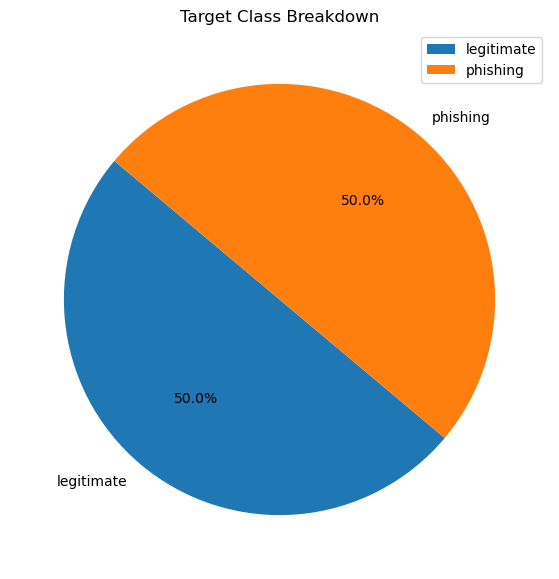

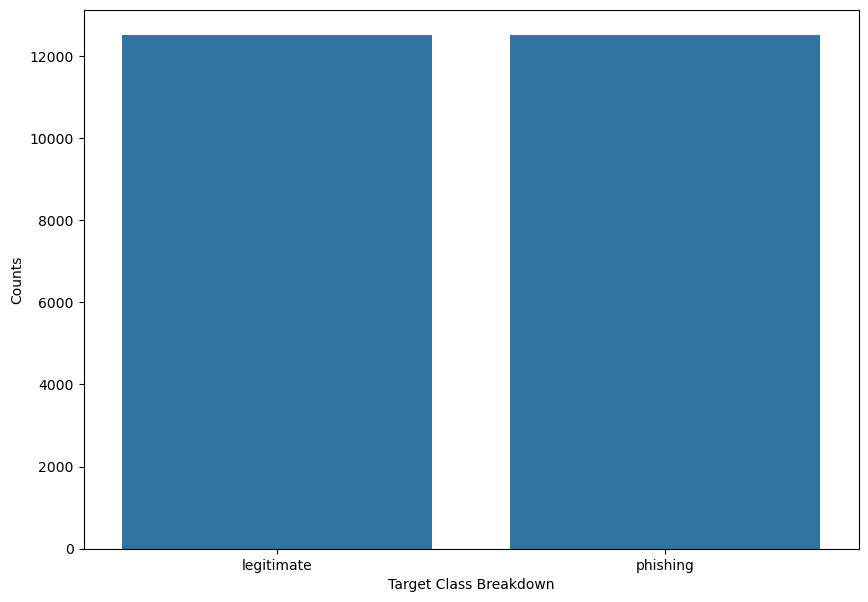

In [46]:
check_class_imbalance(df["label"])

In [47]:
df.drop("whois_data", axis=1, inplace=True)

In [25]:
categorical_types = df.select_dtypes(include="object")
numerical_types = df.select_dtypes(exclude="object")

In [51]:
boolean_types = numerical_types.select_dtypes(include="bool").columns
numerical_types = convert_boolean_cols(numerical_types, boolean_types)

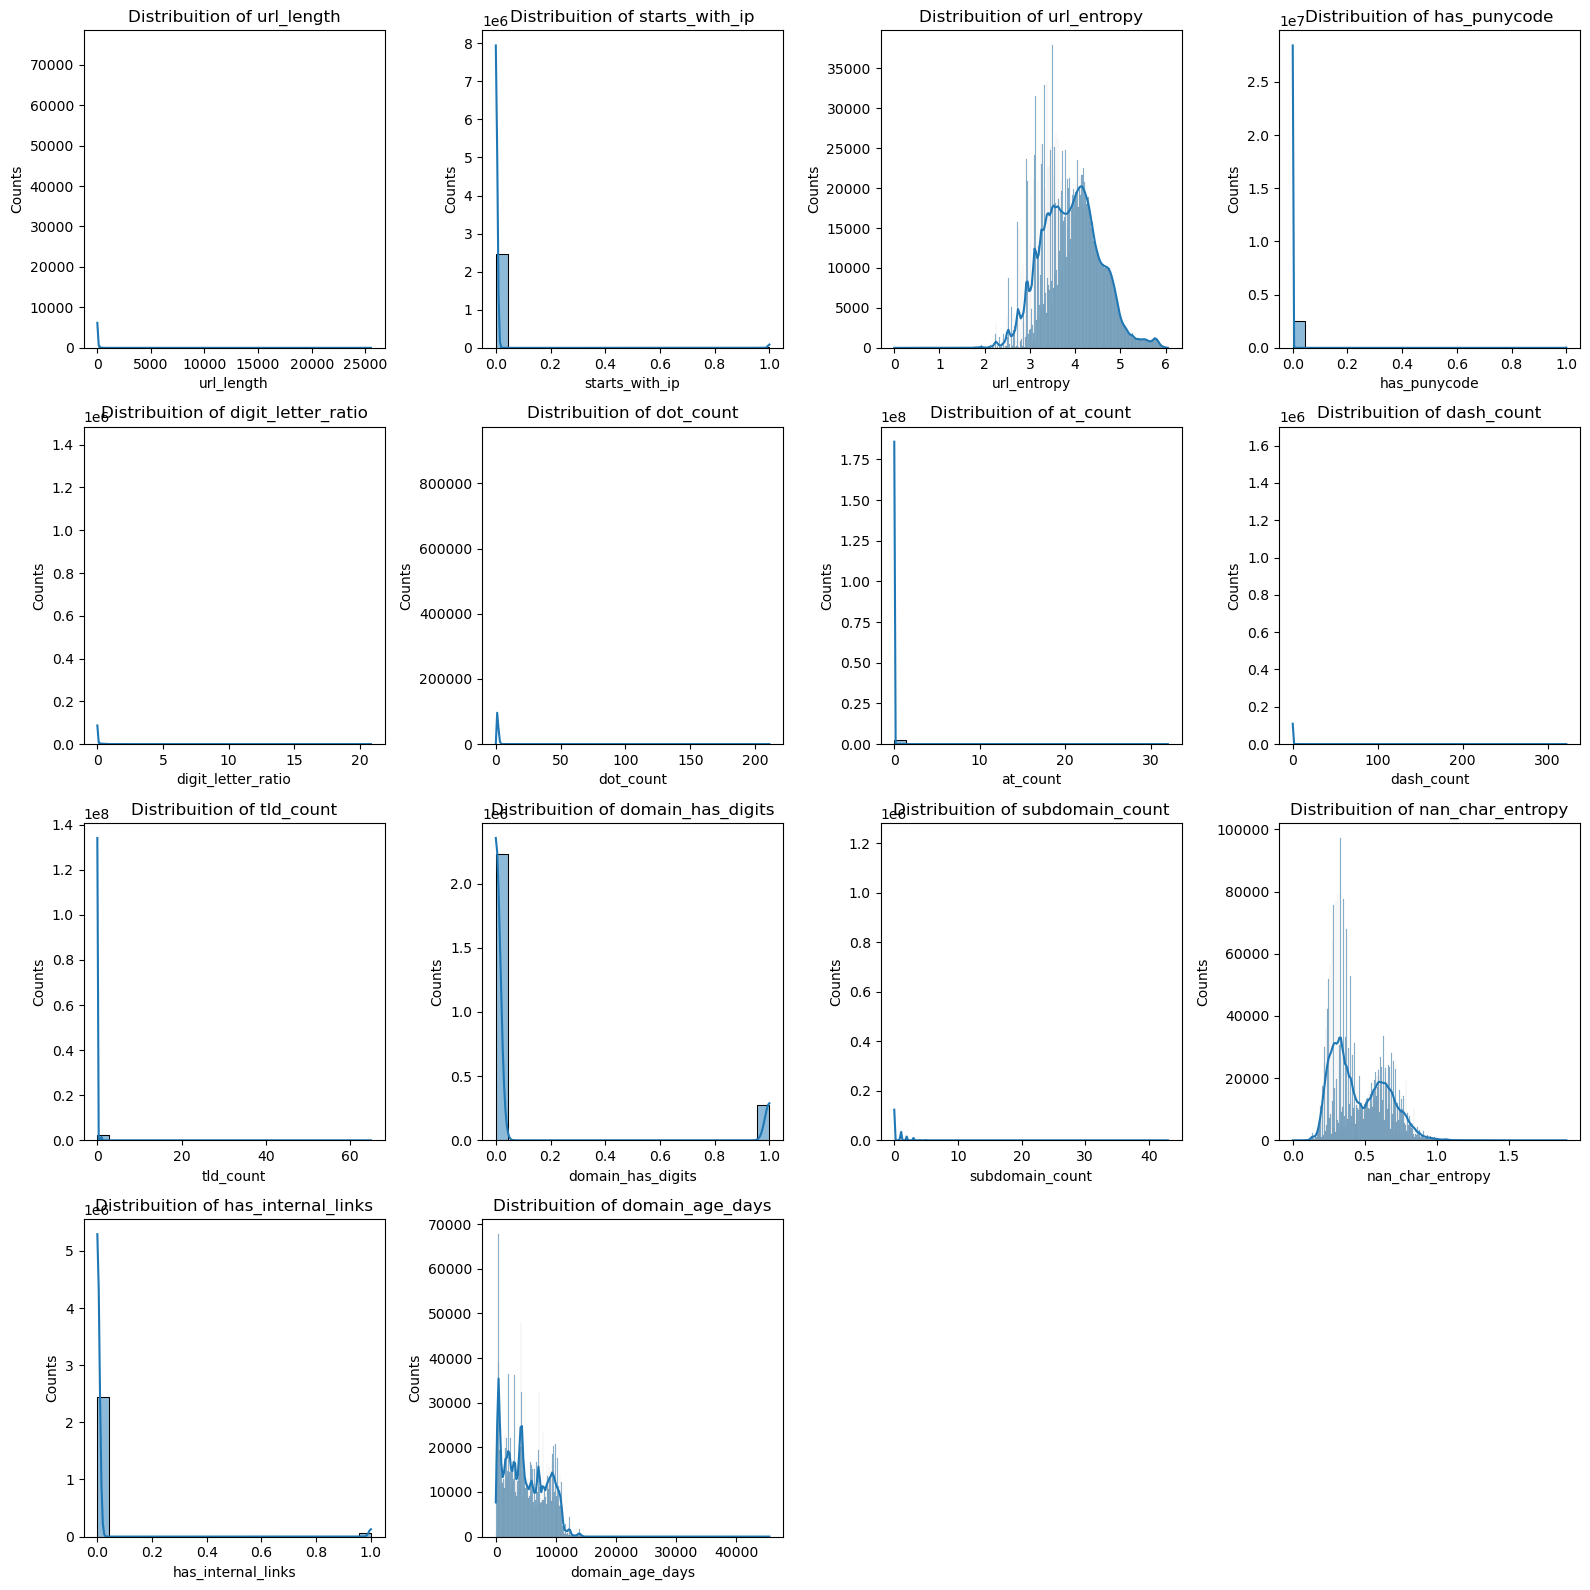

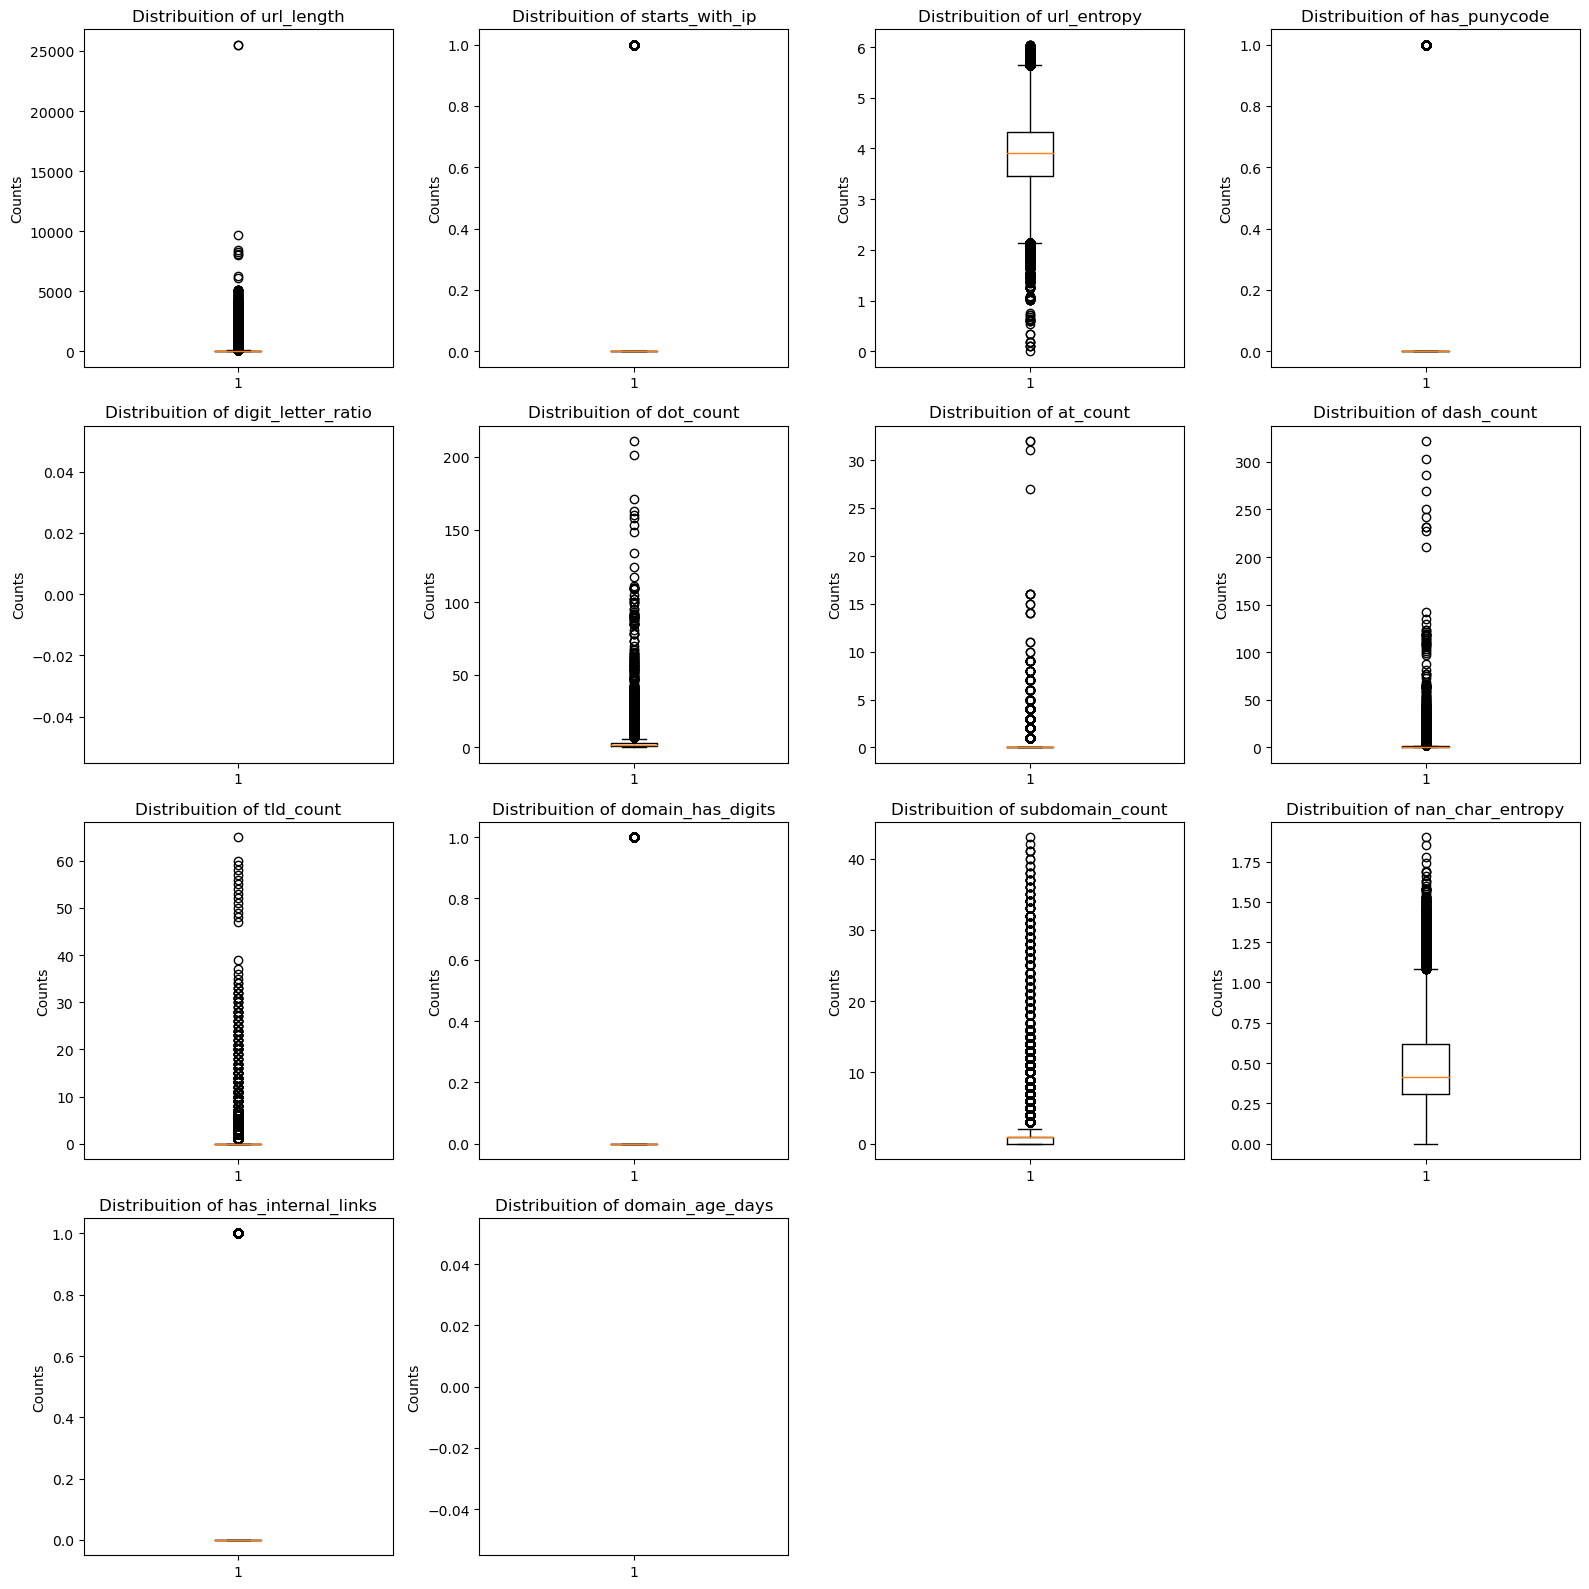

In [52]:
plot_distribution(numerical_types, "hist")
plot_distribution(numerical_types, "box")